In [ ]:
import pandas as pd
import numpy as np
from collections import deque
from sklearn.model_selection import train_test_split
from dataset.netflixDataset import NetflixDataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import DataLoader
import torch
from ThallesNonato.code.models.dmf import DMF
from torch import nn
import tqdm
from dataset.userDataset import UserDataset
from ThallesNonato.code.models.ae import AutoRec

In [2]:
movie_titles = pd.read_csv(
    'dataset/movie_titles.csv',
    encoding='ISO-8859-1',
    header=None,
    index_col=0,  
    names=['Id', 'Year', 'Title1', 'Title2', 'Title3', 'Title4', 'Title5'],  
    engine='python'
)

movie_titles['Name'] = movie_titles[['Title1','Title2','Title3','Title4','Title5']].fillna('').agg(','.join, axis=1)
movie_titles = movie_titles.drop(columns=['Title1','Title2','Title3','Title4','Title5'])

In [3]:
print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))


Shape Movie-Titles:	(17770, 2)


In [4]:
df_raw = pd.read_csv('dataset/combined_data_1.txt', header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])


tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)


user_data = []

for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    tmp_df['Movie'] = movie_id
    
    user_data.append(tmp_df)

df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
6849917,2235475,2.0,2004-06-07,1336
13433261,151539,5.0,2005-10-30,2577
1079041,983355,3.0,2003-02-13,252
16081909,2435449,1.0,2002-08-15,3120
2100361,549094,2.0,2002-04-18,393


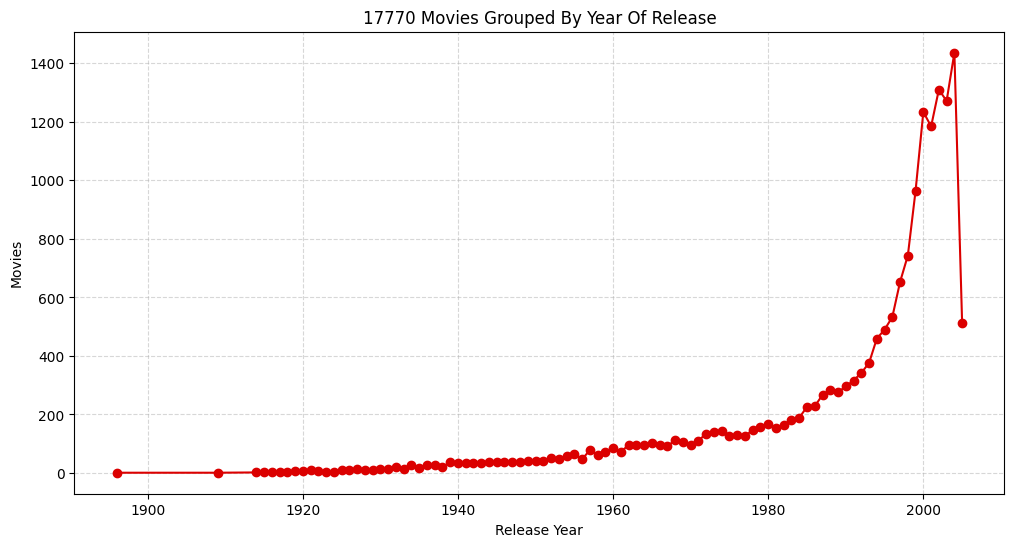

In [5]:
# Get data
data = movie_titles['Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, color='#db0000', marker='o')

# Titles and labels
plt.title(f'{movie_titles.shape[0]} Movies Grouped By Year Of Release')
plt.xlabel('Release Year')
plt.ylabel('Movies')

# Show grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()

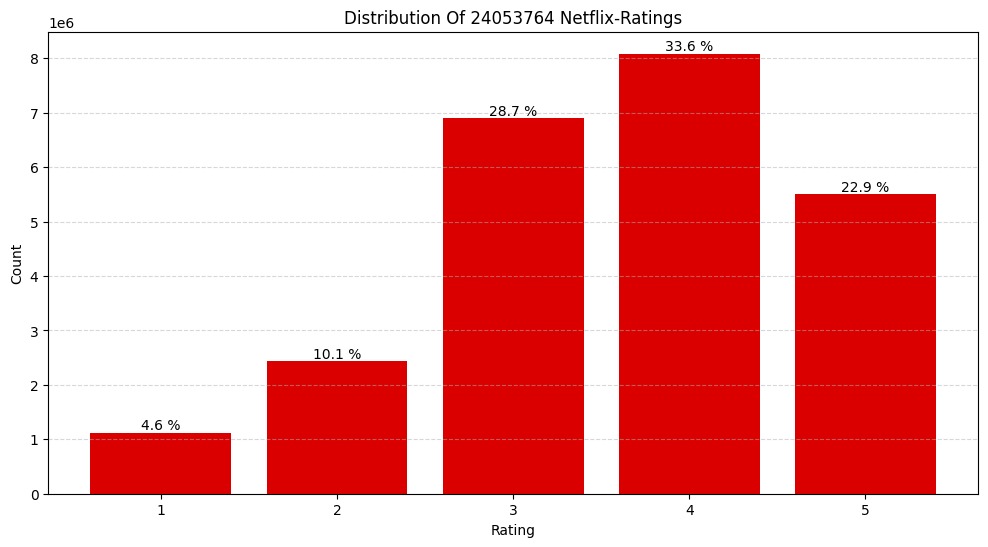

In [6]:
data = df['Rating'].value_counts().sort_index(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.bar(data.index, data.values, color='#db0000')

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    percent = height / df.shape[0] * 100
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{percent:.1f} %', 
            ha='center', va='bottom', color='#000000')

# Titles and labels
ax.set_title(f'Distribution Of {df.shape[0]} Netflix-Ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')

# Optional grid
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

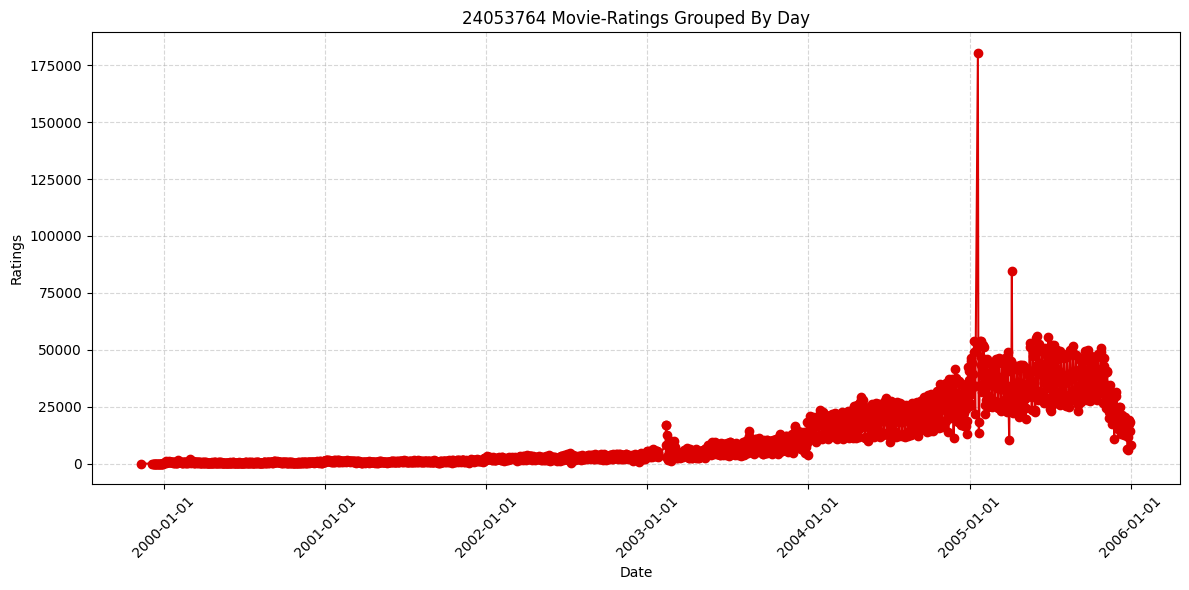

In [7]:
# Prepare data
data = df['Date'].value_counts()
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, color='#db0000', marker='o')

# Titles and labels
plt.title(f'{df.shape[0]} Movie-Ratings Grouped By Day')
plt.xlabel('Date')
plt.ylabel('Ratings')

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

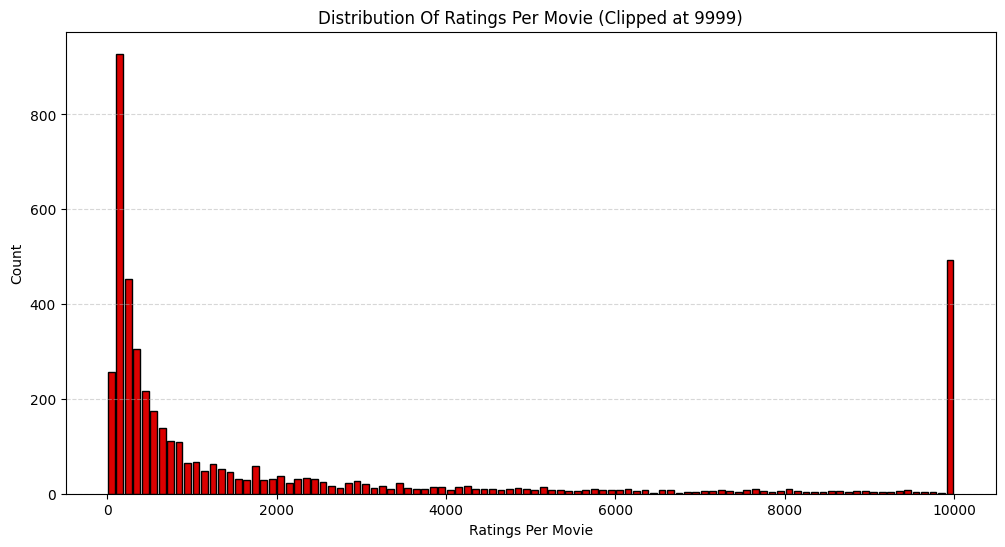

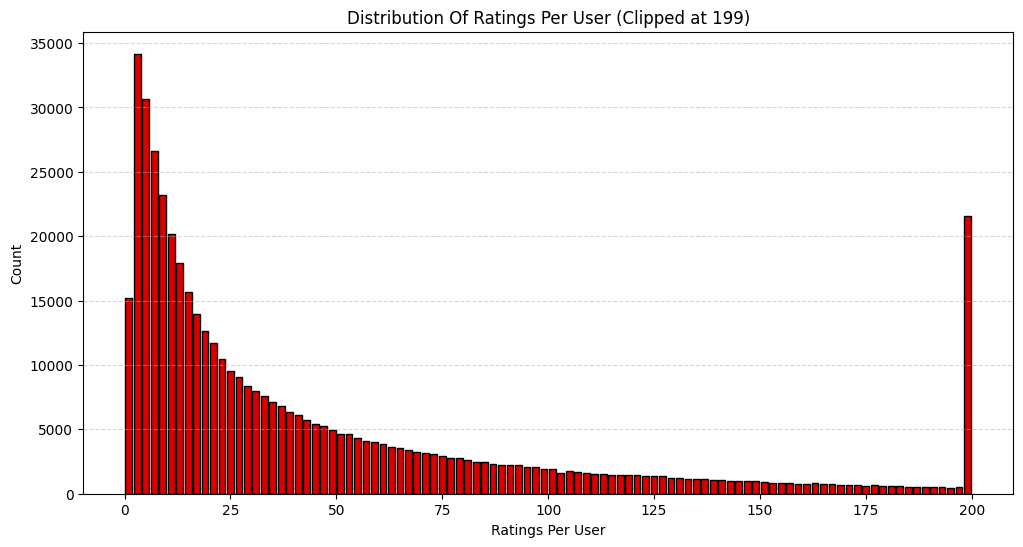

In [8]:
data_movie = df.groupby('Movie')['Rating'].count().clip(upper=9999)

plt.figure(figsize=(12,6))
plt.hist(data_movie.values, bins=range(0, 10001, 100), color='#db0000', edgecolor='black', rwidth=0.8)
plt.title('Distribution Of Ratings Per Movie (Clipped at 9999)')
plt.xlabel('Ratings Per Movie')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Ratings Per User #####
# Get data
data_user = df.groupby('User')['Rating'].count().clip(upper=199)

plt.figure(figsize=(12,6))
plt.hist(data_user.values, bins=range(0, 201, 2), color='#db0000', edgecolor='black', rwidth=0.8)
plt.title('Distribution Of Ratings Per User (Clipped at 199)')
plt.xlabel('Ratings Per User')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [9]:
min_movie_ratings = 10000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(4178032, 4)


In [10]:
from sklearn.model_selection import train_test_split

# Pivot
df_p = df_filterd.pivot_table(index='User', columns='Movie', values='Rating')

X_train, X_test = train_test_split(df_p, test_size=0.2, random_state=42)

In [11]:
X_train

Movie,8,18,28,30,58,77,83,97,108,111,...,4392,4393,4402,4418,4420,4432,4472,4479,4488,4490
User,,,,,,,,,,,,,,,,,,,,,
2590830,NaN,NaN,NaN,3.0,3.0,3.0,NaN,NaN,3.0,3.0,...,4.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1228106,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,5.0,NaN
973622,NaN,NaN,NaN,5.0,4.0,NaN,4.0,NaN,4.0,3.0,...,3.0,NaN,NaN,4.0,3.0,4.0,3.0,4.0,NaN,2.0
60529,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN,NaN
163063,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,5.0,2.0,NaN,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301856,NaN,NaN,4.0,3.0,3.0,NaN,NaN,NaN,NaN,2.0,...,NaN,3.0,4.0,3.0,NaN,3.0,4.0,NaN,NaN,3.0
2381805,NaN,5.0,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,...,NaN,4.0,3.0,5.0,5.0,4.0,3.0,4.0,NaN,NaN
161223,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN


In [12]:
X_train_df = X_train.stack().reset_index()
X_train_df.columns = ['User', 'Movie', 'Rating']
X_test_df = X_train.stack().reset_index()
X_test_df.columns = ['User', 'Movie', 'Rating']
X_test_df

,User,Movie,Rating
0,2590830,30,3.0
1,2590830,58,3.0
2,2590830,77,3.0
3,2590830,108,3.0
4,2590830,111,3.0
...,...,...,...
3341333,42487,4393,4.0
3341334,42487,4402,3.0
3341335,42487,4418,3.0
3341336,42487,4432,4.0


In [13]:
# Usuários e filmes como int
train_user_data  = X_train_df['User'].astype(np.int64).values
train_movie_data = X_train_df['Movie'].astype(np.int64).values

# Ratings como float
train_ratings = X_train_df['Rating'].astype(np.float32).values

# Mesma coisa para teste
test_user_data  = X_test_df['User'].astype(np.int64).values
test_movie_data = X_test_df['Movie'].astype(np.int64).values
test_ratings    = X_test_df['Rating'].astype(np.float32).values


In [22]:
unique_users = np.unique(train_user_data)
user2idx = {u: i for i, u in enumerate(unique_users)}
train_user_data = np.array([user2idx[u] for u in train_user_data])
test_user_data  = np.array([user2idx.get(u, 0) for u in test_user_data])  # usuarios novos -> 0

# Filmes
unique_movies = np.unique(train_movie_data)
movie2idx = {m: i for i, m in enumerate(unique_movies)}
train_movie_data = np.array([movie2idx[m] for m in train_movie_data])
test_movie_data  = np.array([movie2idx.get(m, 0) for m in test_movie_data])  # filmes novos -> 0

# Atualizar num_users e num_movies
num_users = len(user2idx)
num_movies = len(movie2idx)

In [23]:
train_dataset = NetflixDataset(train_user_data, train_movie_data, train_ratings)
test_dataset  = NetflixDataset(test_user_data, test_movie_data, test_ratings)


In [24]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [28]:
model = DMF(num_users, num_movies, user_emb_size=64, movie_emb_size=64)
device = torch.device('cuda')
model.to(device)

DMF(
  (user_embedding): Embedding(16662, 64)
  (movie_embedding): Embedding(491, 64)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [34]:
num_epochs = 5  # aumenta se quiser melhor desempenho

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # tqdm no DataLoader
    for user, movie, rating in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, movie)
        loss = criterion(pred, rating)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * len(user)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")



Epoch 1/5: 100%|██████████| 26105/26105 [03:51<00:00, 112.58it/s]


Epoch 1/5, Train Loss: 0.8257


Epoch 2/5: 100%|██████████| 26105/26105 [03:54<00:00, 111.23it/s]


Epoch 2/5, Train Loss: 0.8175


Epoch 3/5:  22%|██▏       | 5782/26105 [00:56<03:19, 101.67it/s]


KeyboardInterrupt: 

In [41]:
import torch
import torch.nn as nn

class DMF(nn.Module):
    def __init__(self, num_users, num_movies, user_emb_size=20, movie_emb_size=10, hidden_dim=64):
        super().__init__()
        # Embeddings
        self.user_embedding = nn.Embedding(num_users, user_emb_size)
        self.movie_embedding = nn.Embedding(num_movies, movie_emb_size)
        
        # Camadas separadas para embeddings (MLP)
        self.user_fc = nn.Sequential(
            nn.Linear(user_emb_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.movie_fc = nn.Sequential(
            nn.Linear(movie_emb_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Camadas finais após combinar embeddings
        self.output_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, user_id, movie_id):
        u = self.user_embedding(user_id)
        m = self.movie_embedding(movie_id)
        
        u = self.user_fc(u)
        m = self.movie_fc(m)
        
        x = torch.cat([u, m], dim=1)  # concatenar
        out = self.output_fc(x)
        return out.squeeze()


In [42]:
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

# Dataset e DataLoader
train_dataset = NetflixDataset(train_user_data, train_movie_data, train_ratings)
test_dataset  = NetflixDataset(test_user_data, test_movie_data, test_ratings)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DMF(num_users=len(np.unique(train_user_data)),
            num_movies=len(np.unique(train_movie_data)),
            user_emb_size=20,
            movie_emb_size=10,
            hidden_dim=64).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treino
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for user, movie, rating in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)
        
        optimizer.zero_grad()
        pred = model(user, movie)
        loss = criterion(pred, rating)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * len(user)
        
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_dataset):.4f}")


Epoch 1/5:   4%|▍         | 543/13053 [00:05<01:56, 107.66it/s]


KeyboardInterrupt: 

In [43]:
model.eval()
y_pred, y_true = [], []

with torch.no_grad():
    for user, movie, rating in test_loader:
        user = user.to(device)
        movie = movie.to(device)
        rating = rating.to(device)
        
        pred = model(user, movie)
        y_pred.extend(pred.cpu().numpy())
        y_true.extend(rating.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.4f}")


KeyboardInterrupt: 

In [37]:
R = X_train_df.pivot(index='User', columns='Movie', values='Rating')

# Substituir NaN por 0 (ou deixar NaN e usar máscara)
R_filled = np.nan_to_num(R.values, nan=0.0)
R_tensor = torch.tensor(R_filled, dtype=torch.float32)


dataset = UserDataset(R_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

/home/thallesnonato/Área de trabalho/CPE727-2025-03/TrabalhoFinal/ThallesNonato/code/Data/dataset/userDataset.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ratings = torch.tensor(ratings_matrix, dtype=torch.float32)


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoRec(num_items=R.shape[1], hidden_dim=500).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [40]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # tqdm no DataLoader
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)  # reconstrução
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 261/261 [00:01<00:00, 171.21it/s]


Epoch 1/10, Loss: 1.7046


Epoch 2/10: 100%|██████████| 261/261 [00:01<00:00, 254.65it/s]


Epoch 2/10, Loss: 0.8883


Epoch 3/10: 100%|██████████| 261/261 [00:01<00:00, 185.93it/s]


Epoch 3/10, Loss: 0.6454


Epoch 4/10: 100%|██████████| 261/261 [00:01<00:00, 210.29it/s]


Epoch 4/10, Loss: 0.5523


Epoch 5/10: 100%|██████████| 261/261 [00:01<00:00, 187.27it/s]


Epoch 5/10, Loss: 0.4991


Epoch 6/10: 100%|██████████| 261/261 [00:01<00:00, 178.08it/s]


Epoch 6/10, Loss: 0.4671


Epoch 7/10: 100%|██████████| 261/261 [00:00<00:00, 268.09it/s]


Epoch 7/10, Loss: 0.4441


Epoch 8/10: 100%|██████████| 261/261 [00:01<00:00, 184.29it/s]


Epoch 8/10, Loss: 0.4248


Epoch 9/10: 100%|██████████| 261/261 [00:01<00:00, 222.69it/s]


Epoch 9/10, Loss: 0.4025


Epoch 10/10: 100%|██████████| 261/261 [00:01<00:00, 185.88it/s]

Epoch 10/10, Loss: 0.3857
